In [1]:
import numpy as np
import zarr
import dask
from dask.distributed import Client
import multiprocessing
import xarray as xr
import matplotlib.pyplot as plt
import tqdm
import xarray.ufuncs as xu

In [28]:
example_day

<xarray.Dataset>
Dimensions:    (latitude: 3250, longitude: 5500, pattern: 4)
Coordinates:
    dates      datetime64[ns] 2018-02-15
  * latitude   (latitude) float64 55.0 54.98 54.96 54.94 ... -9.96 -9.98 -10.0
  * longitude  (longitude) float64 -100.0 -99.98 -99.96 ... 9.96 9.98 10.0
  * pattern    (pattern) object 'Sugar' 'Fish' 'Flowers' 'Gravel'
Data variables:
    mask       (longitude, latitude, pattern) object dask.array<chunksize=(5500, 3250, 4), meta=np.ndarray>
Attributes:
    author:          Hauke Schulz (hauke.schulz@mpimet.mpg.de)
    created_on:      2020-09-02 18:01 UTC
    description:     North Atlantic NN detections of meso-scale cloud pattern...
    institute:       Max Planck Institut für Meteorologie, Germany
    python_version:  3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) ...
    title:           EUREC4A: IR neural network meso-scale cloud pattern clas...

In [49]:
def calculate_mean(da):

    lat_binned = da.groupby_bins('latitude', lat_bins, labels=lat_center).sum(dim='latitude')
    lat_lon_binned = lat_binned.groupby_bins('longitude', lon_bins, labels=lon_center).sum(dim='longitude')
    
    return lat_lon_binned

template_da = xr.DataArray(np.zeros((1,len(lon_bins)-1, len(lat_bins)-1,4)), dims=['dates', 'longitude_bins', 'latitude_bins', 'pattern'],
                           coords={'dates':[ds_classifications_input.dates.values[0]],
                                   'longitude_bins': lon_center,
                                   'latitude_bins': lat_center,
                                   'pattern': ds_classifications_input.pattern.values}).chunk({'latitude_bins':len(lat_bins)-1, 'longitude_bins':len(lon_bins)-1, 'pattern':1})

In [50]:
chunked_day = example_day.mask.chunk({'latitude':3250, 'longitude':5500, 'pattern':1})

In [51]:
chunked_day.map_blocks(calculate_mean, template=template_da).compute()

IndexError: tuple index out of range

In [15]:
!rm -r "target.zarr"

In [4]:
source = zarr.open(fn_zarr)

In [27]:
source = xr.open_zarr(fn_zarr, decode_times=False, decode_cf=False)

In [28]:
source

,Array,Chunk
Bytes,194.27 GB,71.50 MB
Shape,"(2717, 5500, 3250, 4)","(1, 5500, 3250, 4)"
Count,2718 Tasks,2717 Chunks
Type,bool,numpy.ndarray


In [5]:
from rechunker import rechunk

In [6]:
intermediate = "/scratch/m/m300408/tmp_rechunk_tobedeleted.zarr"
target = "target.zarr"

In [30]:
!rm -r "target.zarr"
!rm -r "/scratch/m/m300408/tmp_rechunk_tobedeleted.zarr"

In [31]:
rechunked = rechunk(source, target_chunks={'mask':
                                           {'dates':1,'pattern':1,'longitude':5500,'latitude':3250},
                                           'dates': None, 'pattern': None, 'latitude': None, 'longitude':None
                                          }, target_store=target,
                    max_mem='6GB',
                    temp_store=intermediate)

NotImplementedError: Can not use auto rechunking with object dtype. We are unable to estimate the size in bytes of object data

In [ ]:
rechunked.execute()

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 3.56 GB -- Worker memory limit: 5.24 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.13 GB -- Worker memory limit: 5.24 GB


In [3]:
import multiprocessing
ncpu = multiprocessing.cpu_count()
processes = False
nworker = 2
threads = ncpu // nworker
print(
    f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}, processes: {processes}",
)
client = Client(
    processes=processes,
    threads_per_worker=threads,
    n_workers=nworker,
    memory_limit="9GB",
)
client

Number of CPUs: 48, number of threads: 24, number of workers: 2, processes: False


Client Scheduler: inproc://10.50.40.21/27515/1 Dashboard: /user/m300408/advanced//proxy/8787/status,Cluster Workers: 2 Cores: 48 Memory: 10.49 GB


In [2]:
xr.__version__

'0.16.2'

In [3]:
fn_zarr = '../data/IR_worldview_everyotherline_NH_daily_pattern_distribution.zarr'

In [5]:
ds_classifications_input = xr.open_zarr(fn_zarr)

In [6]:
ds_classifications_input

,Array,Chunk
Bytes,1.55 TB,572.00 MB
Shape,"(2717, 5500, 3250, 4)","(1, 5500, 3250, 4)"
Count,2718 Tasks,2717 Chunks
Type,object,numpy.ndarray


In [7]:
example_day = ds_classifications_input.sel(dates="2018-02-15")

In [8]:
lat_bins = np.arange(-10,55,1)
lat_center = np.arange(-9.5,54.5,1)
lon_bins = np.arange(-100,10,1)
lon_center = np.arange(-99.5,9.5,1)

In [14]:
mask_all = np.zeros((len(ds_classifications_input.dates),len(lon_bins)-1, len(lat_bins)-1,4))

In [15]:
mask_all.shape

(2717, 109, 64, 4)

In [9]:
dask.config.set({"array.slicing.split_large_chunks": True})

In [10]:
lat_binned = example_day.mask.groupby_bins('latitude', lat_bins, labels=lat_center).sum(dim='latitude')

In [11]:
lat_lon_binned = lat_binned.groupby_bins('longitude', lon_bins, labels=lon_center).sum(dim='longitude')

In [ ]:
mask_all = lat_lon_binned.astype(float)

In [37]:
for d, date in enumerate(tqdm.tqdm(ds_classifications_input.dates)):
    day_sel = ds_classifications_input.sel(dates=date)
    lat_binned = day_sel.mask.groupby_bins('latitude', lat_bins, labels=lat_center).sum(dim='latitude')
    lat_lon_binned = lat_binned.groupby_bins('longitude', lon_bins, labels=lon_center).sum(dim='longitude')
    break
    mask_all[d] = lat_lon_binned.compute().astype(float)

  0%|          | 0/2717 [00:01<?, ?it/s]


In [38]:
lat_binned

<xarray.DataArray 'mask' (longitude: 5500, latitude_bins: 64, pattern: 4)>
dask.array<getitem, shape=(5500, 64, 4), dtype=object, chunksize=(5500, 1, 4), chunktype=numpy.ndarray>
Coordinates:
  * latitude_bins  (latitude_bins) float64 -9.5 -8.5 -7.5 ... 51.5 52.5 53.5
    dates          datetime64[ns] 2010-01-10
  * longitude      (longitude) float64 -100.0 -99.98 -99.96 ... 9.96 9.98 10.0
  * pattern        (pattern) object 'Sugar' 'Fish' 'Flowers' 'Gravel'

In [39]:
lat_lon_binned

,Array,Chunk
Bytes,223.23 kB,32 B
Shape,"(109, 64, 4)","(1, 1, 4)"
Count,45254 Tasks,6976 Chunks
Type,object,numpy.ndarray


In [12]:
ds_out = xr.Dataset()

In [15]:
ds_classifications_input

,Array,Chunk
Bytes,1.55 TB,572.00 MB
Shape,"(2717, 5500, 3250, 4)","(1, 5500, 3250, 4)"
Count,2718 Tasks,2717 Chunks
Type,object,numpy.ndarray


In [17]:
ds_out['counts'] = xr.DataArray(mask_all, dims=['time', 'longitude', 'latitude', 'class'],
                                coords={'time':ds_classifications_input.dates.values,
                                        'longitude': lon_center,
                                        'latitude': lat_center,
                                        'class': ds_classifications_input.pattern.values
                                       })

In [18]:
# ds_out.counts.encoding['dtype'] = 'float'

In [19]:
# ds_out = ds_out.rename({'pattern':'class', 'dates':'time', 'longitude_bins': 'longitude', 'latitude_bins': 'latitude'})

In [20]:
ds_out.to_netcdf(encoding={'time':{'dtype':object}, 'class':{'_FillValue':None}}, path="Daily_1x1_MODIS-IR_NorthAtlantic_SGFF.nc")

In [21]:
ds_out

<xarray.Dataset>
Dimensions:    (class: 4, latitude: 64, longitude: 109, time: 2717)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-10 2010-01-11 ... 2020-07-27
  * longitude  (longitude) float64 -99.5 -98.5 -97.5 -96.5 ... 5.5 6.5 7.5 8.5
  * latitude   (latitude) float64 -9.5 -8.5 -7.5 -6.5 ... 50.5 51.5 52.5 53.5
  * class      (class) object 'Sugar' 'Fish' 'Flowers' 'Gravel'
Data variables:
    counts     (time, longitude, latitude, class) float64 0.0 0.0 ... 0.0 0.0

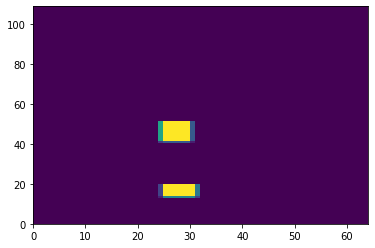

In [39]:
plt.pcolormesh(lat_lon_binned.sel(pattern='Sugar').astype('float'))

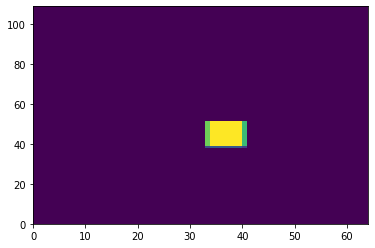

In [40]:
plt.pcolormesh(lat_lon_binned.sel(pattern='Flowers').astype('float'))

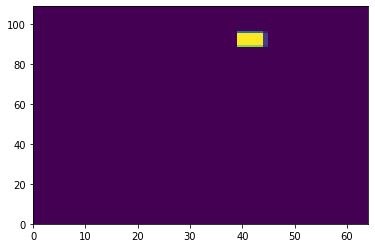

In [41]:
plt.pcolormesh(lat_lon_binned.sel(pattern='Fish').astype('float'))

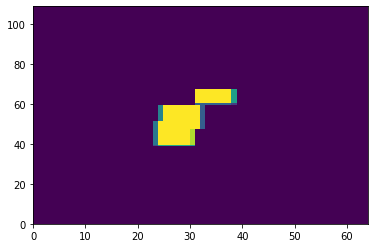

In [42]:
plt.pcolormesh(lat_lon_binned.sel(pattern='Gravel').astype('float'))

In [59]:
xr.__version__

'0.14.1'

In [43]:
!pwd

/mnt/lustre02/work/mh0010/m300408/CloudMorphology/analysis
